## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    rc={
        "axes.titlesize": 36,
        "axes.labelsize": 32,
        "lines.linewidth": 5,
        "lines.markersize": 24,
        "xtick.labelsize": 32,
        "ytick.labelsize": 32,
        'legend.fontsize': 24,
        'figsize': (15, 15),
    }
)
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')

FIG_DIR = os.path.join(
    os.path.dirname(os.path.dirname(glucose_ts.__file__)),
    'presentations',
    'results_outline',
    'images'
)


<Figure size 432x288 with 0 Axes>

# Callibration in Glucose Water solution

## Load and Normalize the data


In [2]:
calibration_df = pd.read_csv(os.path.join(DATA_DIR, 'regression.csv'))
calibration_df['voltage (V)'] = calibration_df['Voltage (mV)'] / 1000.

## Fit a Linear Regression Model

In [3]:
import sklearn.linear_model

lr_model = sklearn.linear_model.LinearRegression().fit(calibration_df['voltage (V)'].values.reshape(-1, 1), calibration_df['concentration (g/l)'])
lr_model.predict(np.linspace(.95, 1.02, 100).reshape(-1, 1))

array([ 5.18595998,  5.1251253 ,  5.06429063,  5.00345595,  4.94262128,
        4.8817866 ,  4.82095193,  4.76011725,  4.69928258,  4.63844791,
        4.57761323,  4.51677856,  4.45594388,  4.39510921,  4.33427453,
        4.27343986,  4.21260518,  4.15177051,  4.09093583,  4.03010116,
        3.96926649,  3.90843181,  3.84759714,  3.78676246,  3.72592779,
        3.66509311,  3.60425844,  3.54342376,  3.48258909,  3.42175441,
        3.36091974,  3.30008507,  3.23925039,  3.17841572,  3.11758104,
        3.05674637,  2.99591169,  2.93507702,  2.87424234,  2.81340767,
        2.75257299,  2.69173832,  2.63090365,  2.57006897,  2.5092343 ,
        2.44839962,  2.38756495,  2.32673027,  2.2658956 ,  2.20506092,
        2.14422625,  2.08339157,  2.0225569 ,  1.96172223,  1.90088755,
        1.84005288,  1.7792182 ,  1.71838353,  1.65754885,  1.59671418,
        1.5358795 ,  1.47504483,  1.41421016,  1.35337548,  1.29254081,
        1.23170613,  1.17087146,  1.11003678,  1.04920211,  0.98

/home/christoph/.virtualenvs/glucose-ts/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


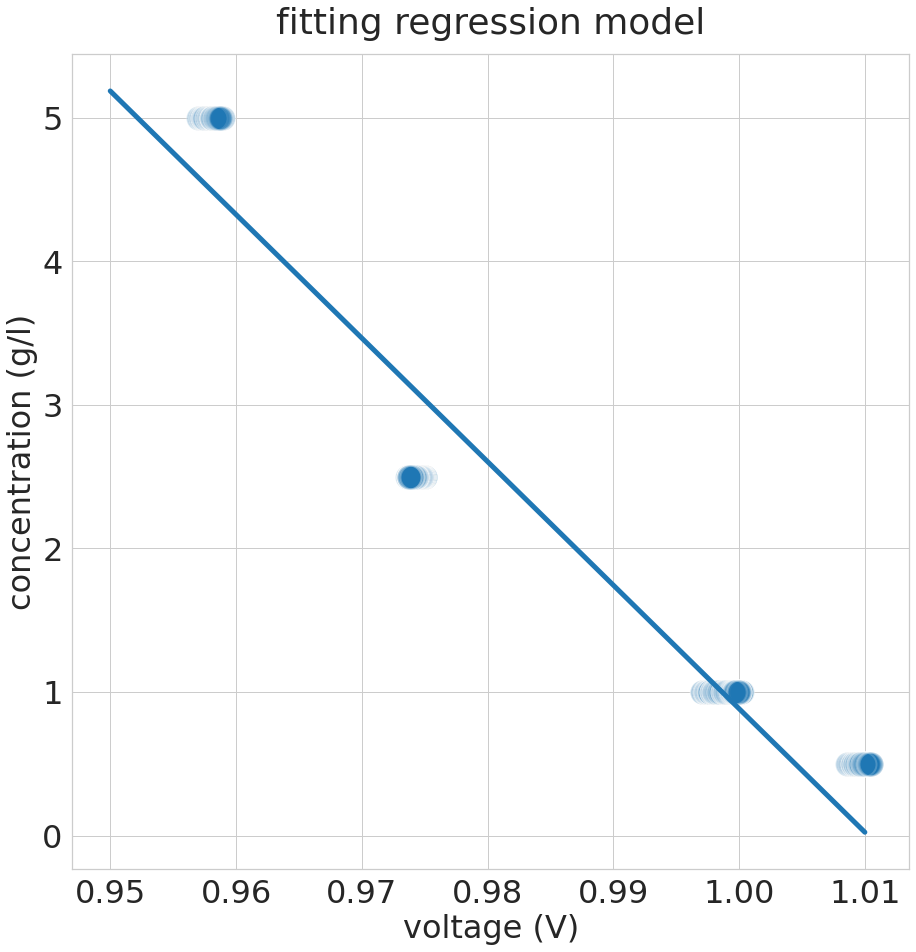

In [4]:
fig, axises = plt.subplots(
    1,
    1,
    figsize=(15, 15)
)

sns.scatterplot(
    data=calibration_df,
    x='voltage (V)',
    y='concentration (g/l)',
    ax=axises,
    alpha=.2
)

sns.lineplot(
    np.linspace(.95, 1.01, 50),
    lr_model.predict(np.linspace(.95, 1.01, 50).reshape(-1, 1))
)

axises.set_title('fitting regression model', pad=20)

fig.savefig(
    os.path.join(FIG_DIR, 'regression_pure_solution.png'),
    facecolor='w',
    edgecolor='w',
    transparent=True,
)

In [5]:
from sklearn.metrics import mean_squared_error
import math

mean_squared_error(
    lr_model.predict(calibration_df['voltage (V)'].values.reshape(-1, 1)),
    calibration_df['concentration (g/l)']
)

0.2134445901945714

# Calibration in Medium

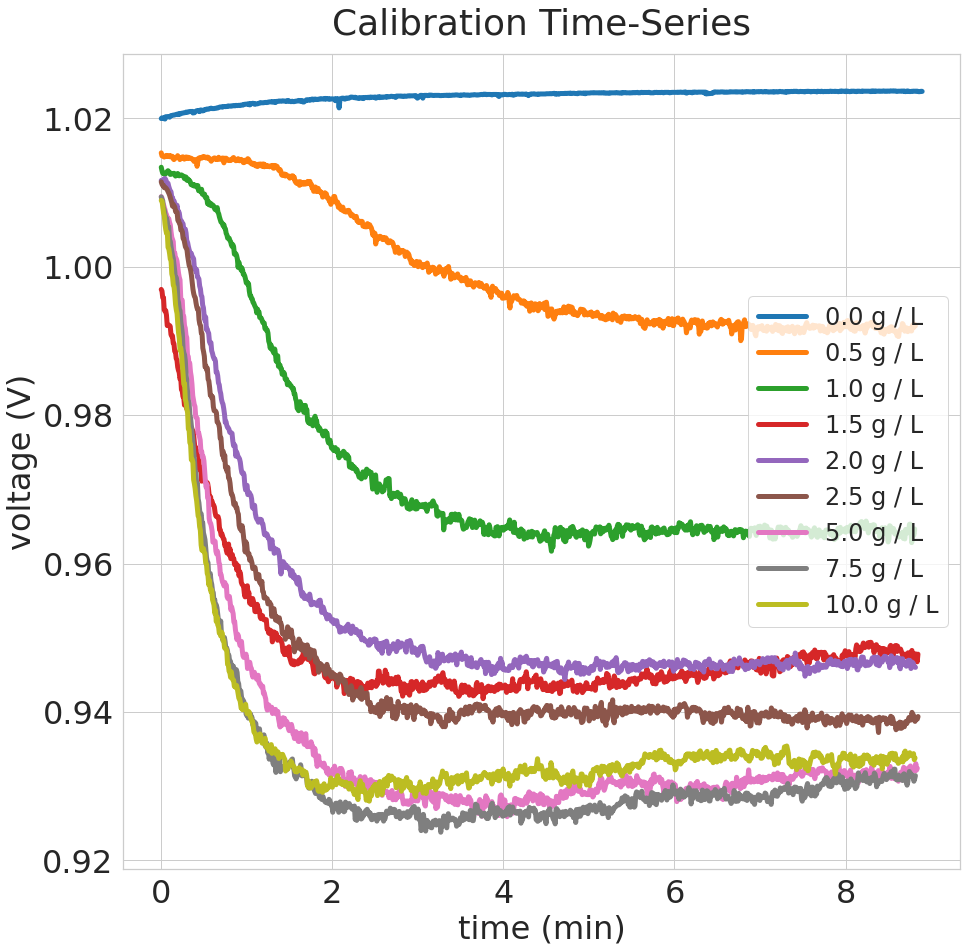

In [6]:
calibration_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'calibration', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'calibration'
            )
        )
    ],
    key=lambda one: one.real_concentration
)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for one_curve in calibration_curves:
    
    ax.plot(
        one_curve.points_in_time,
        one_curve.voltages,
        label='%3.1f g / L' % one_curve.real_concentration,
    )

ax.set_xlabel('time (min)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Time-Series', pad=20)
ax.legend()

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_time_series.png'
    ),
    transparent=True,
)


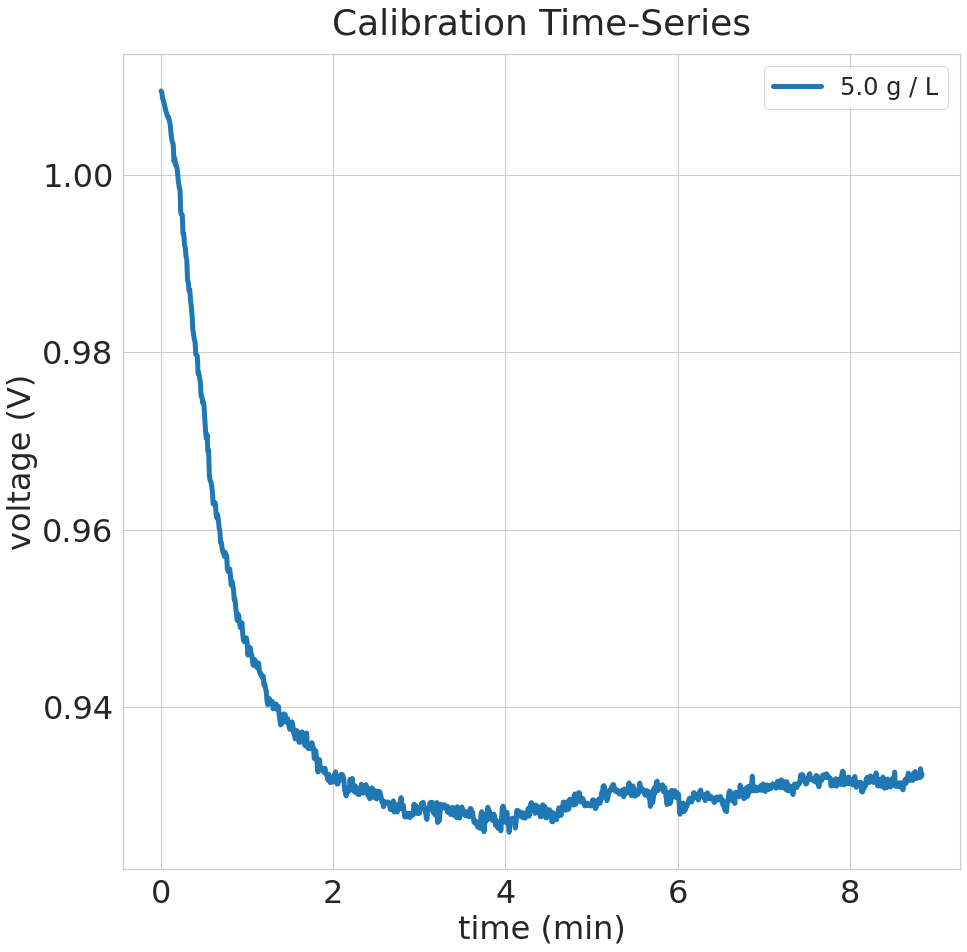

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.plot(
    calibration_curves[-3].points_in_time,
    calibration_curves[-3].voltages,
    label='%3.1f g / L' % calibration_curves[-3].real_concentration,
)

ax.set_xlabel('time (min)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Time-Series', pad=20)
ax.legend()

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_5_gramm.png'
    ),
    transparent=True,
)


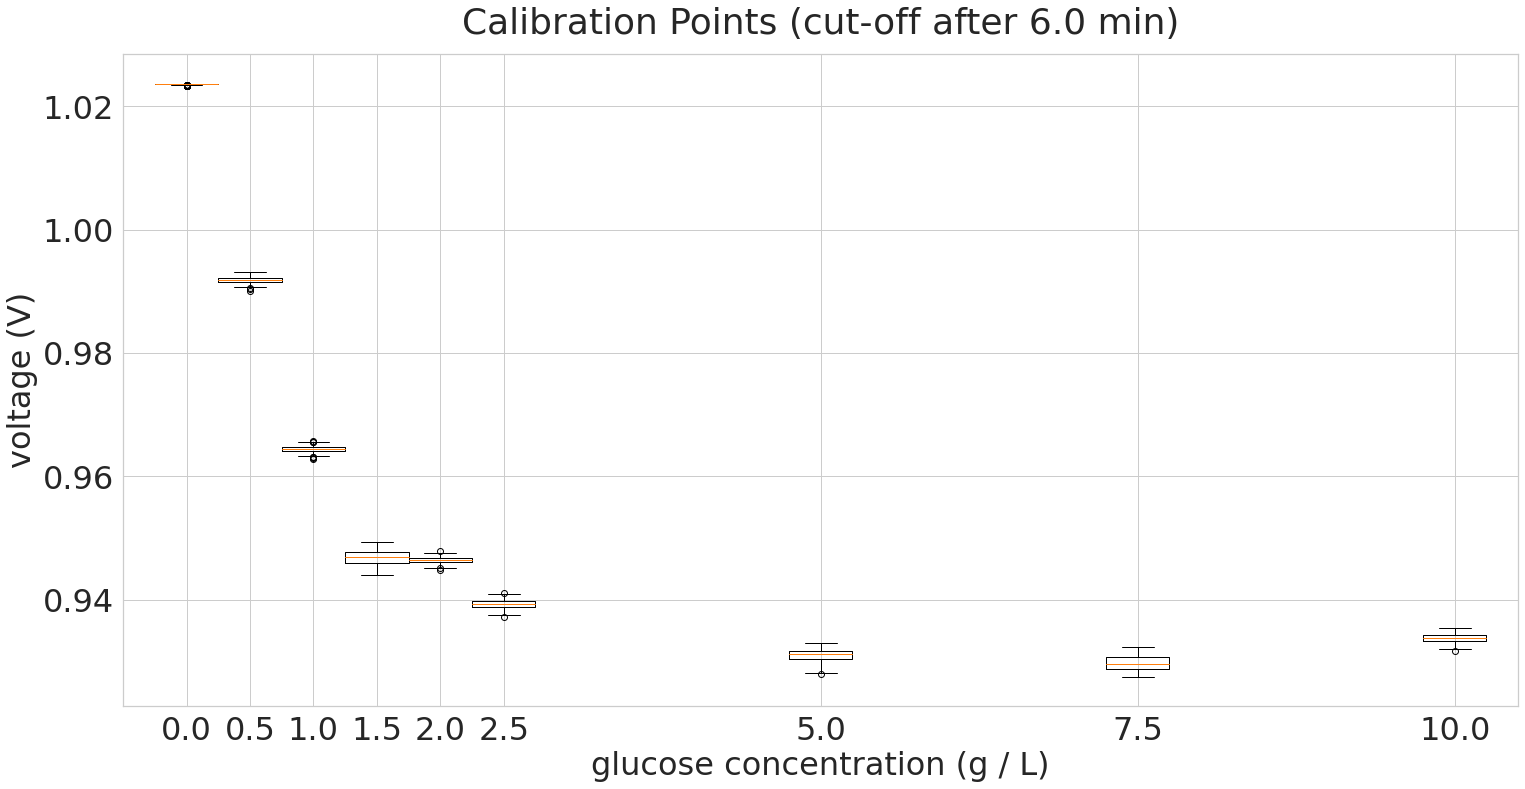

In [8]:
CUT_OFF = 6.

concentrations, calibration_subsets = zip(*[
    (
        curve.real_concentration,
        curve.voltages[curve.points_in_time > CUT_OFF],
    )
    
    for curve in calibration_curves
])
 
    
fig, ax = plt.subplots(1, 1, figsize=(25, 12))

    
ax.boxplot(
    calibration_subsets,
    positions=concentrations,
)

ax.set_xlabel('glucose concentration (g / L)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Points (cut-off after %s min)' % CUT_OFF, pad=20)

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_curve.png'
    ),
    transparent=True,
)


In [9]:
max(concentrations)

10.0

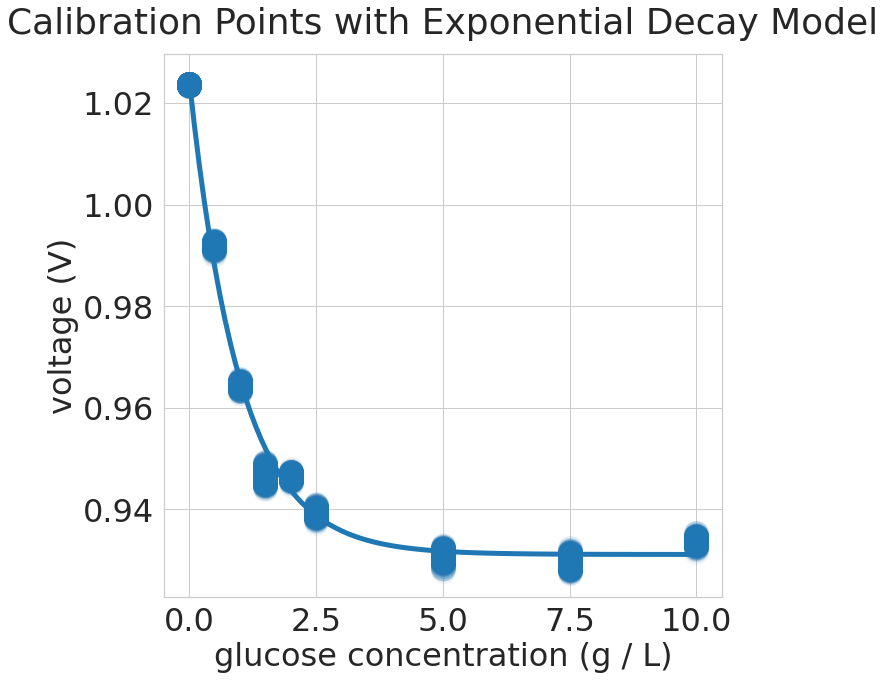

In [10]:
import functools

expanded_concentrations = np.array([
    one_concentration 
    for (one_concentration, voltages) in zip(concentrations, calibration_subsets)
    for _ in range(len(voltages))
])
voltages = functools.reduce(
    lambda first, second: np.concatenate([first, second]),
    calibration_subsets
)


model = glucose_ts.models.exponential_decay.ExponentialDecay().fit(
    expanded_concentrations.reshape(-1, 1),
    voltages
)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    
ax.scatter(
    expanded_concentrations,
    voltages,
    alpha=0.05
)

ax.plot(
    np.linspace(0, 10, 100),
    model.predict(np.linspace(0, 10, 100))
)

ax.set_xlabel('glucose concentration (g / L)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Points with Exponential Decay Model', pad=20)

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_curve_exp_decay.png'
    ),
    transparent=True,
)

In [11]:
import sklearn.metrics

sklearn.metrics.r2_score(
    model.predict(expanded_concentrations.reshape(-1, 1)),
    voltages,
)

0.9917419626862912

In [12]:
model.parameter.K

0.9310985874925324

# Predicting Glucose from Voltages

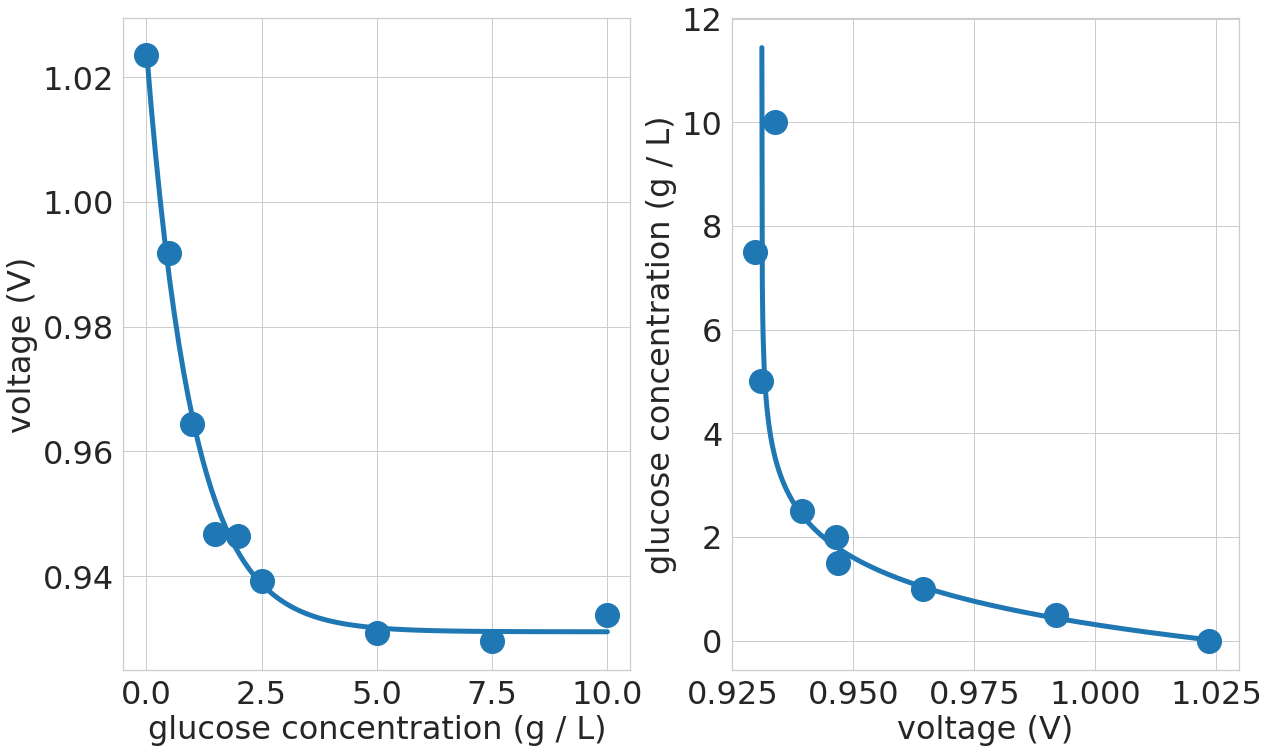

In [13]:
import functools

final_voltages = np.array([
    np.mean(volts)
    for volts in calibration_subsets
])


model = glucose_ts.models.exponential_decay.ExponentialDecay().fit(
    np.array(concentrations).reshape(-1, 1),
    final_voltages
)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].scatter(
    concentrations,
    final_voltages
)

ax[0].plot(
    np.linspace(0, 10, 100),
    model.predict(np.linspace(0, 10, 100))
)

ax[0].set_ylabel('voltage (V)')
ax[0].set_xlabel('glucose concentration (g / L)')

# ax[0].set_title('Calibration Points with Exponential Decay Model', pad=20)


ax[1].scatter(
    final_voltages,
    concentrations,
)

ax[1].plot(
    np.linspace(model.parameter.K + 1e-6, 1.025, 1000),
    model.inverse(np.linspace(model.parameter.K + 1e-6, 1.025, 1000))
)

ax[1].set_xlabel('voltage (V)')
ax[1].set_ylabel('glucose concentration (g / L)')



fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_glucose_from_voltage.png'
    ),
    transparent=True,
)

# Experiments with different least squares

In [14]:
import functools

final_voltages = np.array([
    np.mean(volts)
    for volts in calibration_subsets
])


model = glucose_ts.models.exponential_decay.ExponentialDecay().fit_least_squares(
    np.array(concentrations)[:-1],
    final_voltages[:-1], 
    loss='cauchy'
)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].scatter(
    concentrations,
    final_voltages
)

ax[0].plot(
    np.linspace(0, 10, 100),
    model.predict(np.linspace(0, 10, 100))
)

ax[0].set_ylabel('voltage (V)')
ax[0].set_xlabel('glucose concentration (g / L)')

# ax[0].set_title('Calibration Points with Exponential Decay Model', pad=20)


ax[1].scatter(
    final_voltages,
    concentrations,
)

ax[1].plot(
    np.linspace(model.parameter.K + 1e-6, 1.025, 1000),
    model.inverse(np.linspace(model.parameter.K + 1e-6, 1.025, 1000))
)

ax[1].set_xlabel('voltage (V)')
ax[1].set_ylabel('glucose concentration (g / L)')



# fig.savefig(
#     os.path.join(
#         FIG_DIR,
#         'calibration_glucose_from_voltage.png'
#     ),
#     transparent=True,
# )

AttributeError: 'ExponentialDecay' object has no attribute 'fit_least_squares'

In [ ]:
model.inverse(final_voltages), concentrations

In [ ]:
final_voltages, concentrations[:-1]

In [ ]:
model.predict(np.linspace(0.90, 1.02, 100))

In [ ]:

model = glucose_ts.models.exponential_decay.InverseExpDecay().fit(
    final_voltages[:-1],
    concentrations[:-1],
)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    
ax.scatter(
    final_voltages,
    concentrations,
)

ax.plot(
    np.linspace(0.90, 1.02, 100),
    model.predict(np.linspace(0.90, 1.02, 100))
)

ax.set_xlabel('voltage (V)')
ax.set_ylabel('glucose concentration (g / L)')

ax.set_title('Calibration Points with Inverse Exponential Decay Model', pad=20)

# fig.savefig(
#     os.path.join(
#         FIG_DIR,
#         'calibration_curve_exp_decay.png'
#     ),
#     transparent=True,
# )

## Measuring the Glucose Accuracy

In [ ]:
predictions = model.inverse(final_voltages)

g_of_v_r2 = sklearn.metrics.r2_score(
    predictions[~ np.isnan(predictions)], np.array(concentrations)[~ np.isnan(predictions)]
)

g_of_v_mae = sklearn.metrics.mean_absolute_error(
    predictions[~ np.isnan(predictions)], np.array(concentrations)[~ np.isnan(predictions)]
)

g_of_v_rmse = math.sqrt(
    sklearn.metrics.mean_squared_error(
        predictions[~ np.isnan(predictions)],
        np.array(concentrations)[~ np.isnan(predictions)]
    )
)

print('For g(v) we have got an R2 of %6.4f and a mae of %6.4f g / L and an rmse of %6.4f g / L' % (g_of_v_r2, g_of_v_mae, g_of_v_rmse))

In [ ]:
predictions = model.inverse(final_voltages)

g_of_v_r2 = sklearn.metrics.r2_score(
    predictions[:-3], np.array(concentrations)[:-3]
)

g_of_v_mae = sklearn.metrics.mean_absolute_error(
    predictions[:-3], np.array(concentrations)[:-3]
)

g_of_v_rmse = math.sqrt(
    sklearn.metrics.mean_squared_error(
        predictions[:-3],
        np.array(concentrations)[:-3]
    )
)

print('For g(v) for all compounds up to 2.5 g / L we have got an R2 of %6.4f and a mae of %6.4f g / L and an rmse of %6.4f g / L' % (g_of_v_r2, g_of_v_mae, g_of_v_rmse ))

In [ ]:
predictions = model.inverse(final_voltages)

v_of_g_r2 = sklearn.metrics.r2_score(
    final_voltages, model.predict(np.array(concentrations))
)

v_of_g_mae = sklearn.metrics.mean_absolute_error(
    final_voltages, model.predict(np.array(concentrations))
)

v_of_g_rmse = math.sqrt(
    sklearn.metrics.mean_squared_error(
        final_voltages,
        model.predict(np.array(concentrations))
    )
)


print('For v(g) we have got an R2 of %6.4f and a mae of %6.4f V and an rmse of %6.4f V' % (v_of_g_r2, v_of_g_mae, v_of_g_rmse))

In [ ]:
import functools
import scipy as scp

final_voltages = np.array([
    np.mean(volts)
    for volts in calibration_subsets
])

x = final_voltages

labels = concentrations

def exp_decay_function(inputs, A, B, M):
    return A * np.exp(- B * (inputs - M))

def mononom(inputs, a, b, c):
    c = 4
    return a * ((inputs - b) ** c)

def objective_function(params):
    log_likelihood = np.sum([
        scp.stats.norm.logpdf(
            label,
            loc=prediction,
            scale=1.
        )
        for label, prediction in zip(
            labels,
            mononom(x, *params)
#             exp_decay_function(x, *params)
        )
    ])
    # we want to maximize the posterior distribution which is
    # equivalent to minimize the negative log posterior
    return -1 * (log_likelihood)

results = scp.optimize.minimize(
    fun=objective_function,
    x0=[1, 1, 1],
    bounds=scp.optimize.Bounds(
        lb=[0, 0, 1],
        ub=[np.inf, np.inf, np.inf]
    )
)
print(results.x)



fig, ax = plt.subplots(1, 1, figsize=(20, 20))


ax.scatter(
    final_voltages,
    concentrations,
)

ax.plot(
    np.linspace(0.925, 1.025, 100),
#     exp_decay_function(np.linspace(0.925, 1.025, 100), *results.x)
    mononom(np.linspace(0.925, 1.025, 100), *results.x)
)

ax.set_xlabel('voltage (V)')
ax.set_ylabel('glucose concentration (g / L)')



# fig.savefig(
#     os.path.join(
#         FIG_DIR,
#         'calibration_glucose_from_voltage_exp.png'
#     ),
#     transparent=True,
# )

In [89]:
unlabeled_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, file))
        for file in os.listdir(DATA_DIR)
        if file.startswith('Data')
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'batch_samples', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'batch_samples'
            )
        )
    ],
    key=lambda one: one.real_concentration
)
len(unlabeled_curves)


60

In [94]:

models_and_validation_data = glucose_ts.evaluation.both_models.cross_training(
        labeled_ts=calibration_curves,
        unlabeled_ts=unlabeled_curves,
        num_folds=3,
        voltage_model_fn=glucose_ts.models.generalized_logistics.train_gl_model,
        glucose_model_fn=functools.partial(
            glucose_ts.models.exponential_decay.get_glucose_model,
            avg_start_idx=700,
        )
    )





ExpDParameter(A=1.022983262270052, K=0.9312431361515138, B=1.000599099363461)
ExpDParameter(A=1.0284903190205836, K=0.9299685908885598, B=0.9990945651946366)
ExpDParameter(A=1.0250796930526918, K=0.9314641568906791, B=0.9999152150157916)


In [71]:
unlabeled_curves

[GlucoseTS(points_in_time=array([0.00000000e+00, 8.90000000e-03, 1.78666667e-02, 2.68166667e-02,
        3.55166667e-02, 4.42333333e-02, 5.32000000e-02, 6.21500000e-02,
        7.09166667e-02, 7.98833333e-02, 8.88833333e-02, 9.76666667e-02,
        1.06616667e-01, 1.15333333e-01, 1.24250000e-01, 1.33200000e-01,
        1.42100000e-01, 1.50816667e-01, 1.59766667e-01, 1.68666667e-01,
        1.77383333e-01, 1.86333333e-01, 1.95266667e-01, 2.04200000e-01,
        2.13116667e-01, 2.21850000e-01, 2.30783333e-01, 2.39733333e-01,
        2.48666667e-01, 2.57583333e-01, 2.66550000e-01, 2.75450000e-01,
        2.84150000e-01, 2.92866667e-01, 3.01816667e-01, 3.10716667e-01,
        3.19450000e-01, 3.28500000e-01, 3.37483333e-01, 3.46200000e-01,
        3.55133333e-01, 3.63850000e-01, 3.72783333e-01, 3.81750000e-01,
        3.90666667e-01, 3.99400000e-01, 4.08333333e-01, 4.17266667e-01,
        4.26183333e-01, 4.34900000e-01, 4.43850000e-01, 4.52783333e-01,
        4.61716667e-01, 4.70633333e-01,

In [95]:
CUT_OFF_IDX = 250


volt_and_glc_predictions_250 = [
    glucose_ts.evaluation.both_models.glucose_performance(
        glucose_time_series=val_data,
        glucose_model=glucose_model,
        voltage_model=volt_model,
        cut_off_idx=250,
    )
    for volt_model, glucose_model, val_data in models_and_validation_data
]    

volt_and_glc_predictions_400 = [
    glucose_ts.evaluation.both_models.glucose_performance(
        glucose_time_series=val_data,
        glucose_model=glucose_model,
        voltage_model=volt_model,
        cut_off_idx=400,
    )
    for volt_model, glucose_model, val_data in models_and_validation_data
]    


    

/home/christoph/git_projects/glucose-prediction/glucose_ts/models/exponential_decay.py:231: RuntimeWarning: invalid value encountered in log
  return -1 / B * np.log((voltages - K) / (A - K))


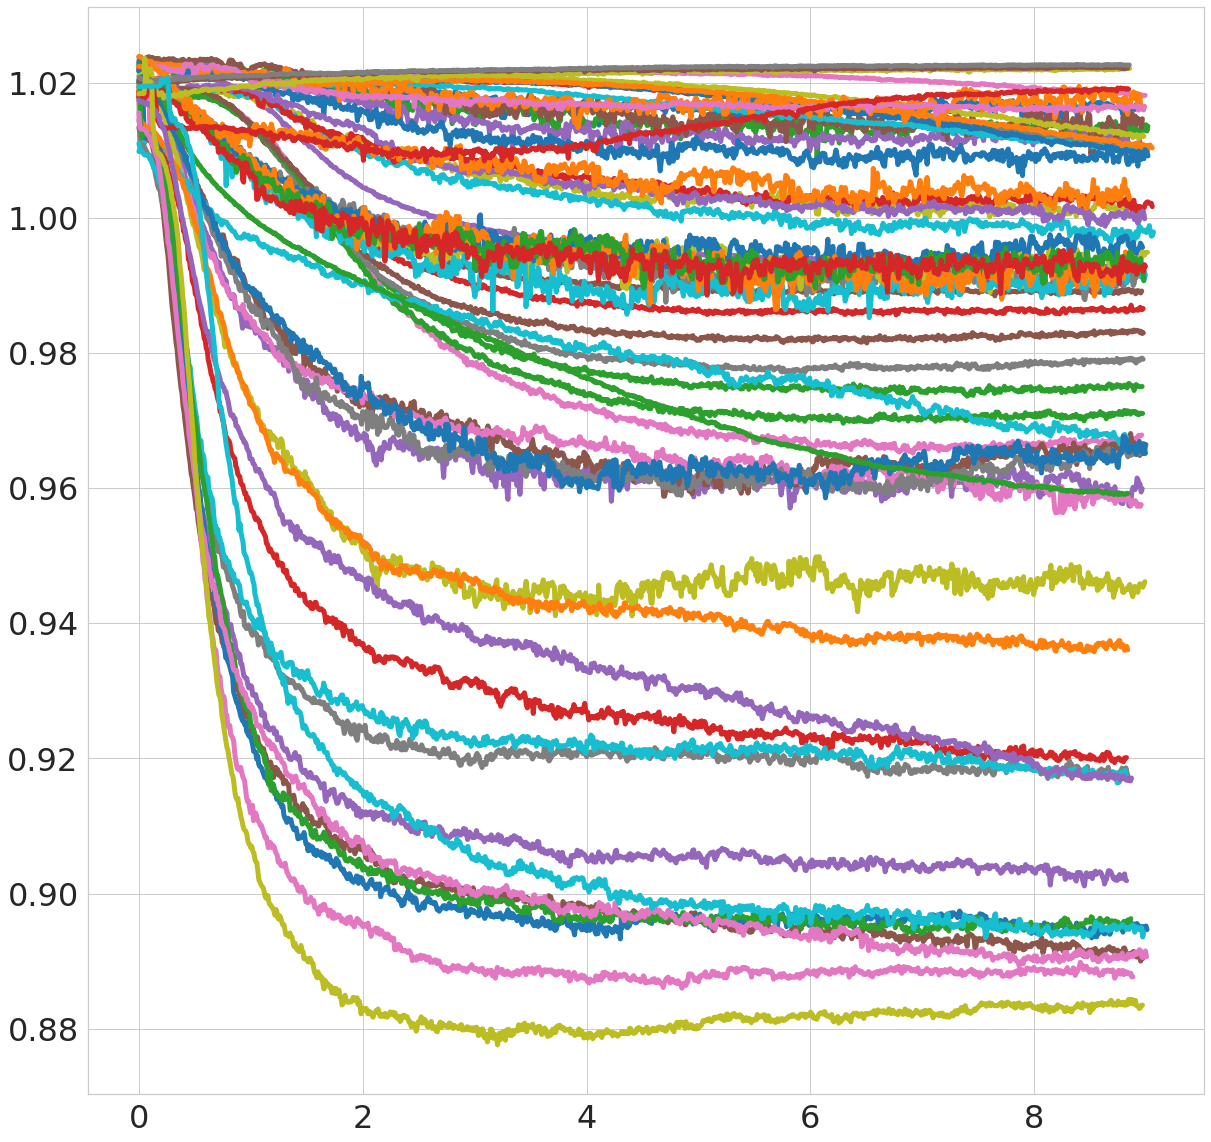

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for unlabeled_series in unlabeled_curves:
    ax.plot(unlabeled_series.points_in_time, unlabeled_series.voltages)

# Bo's plot DONT TOUCH

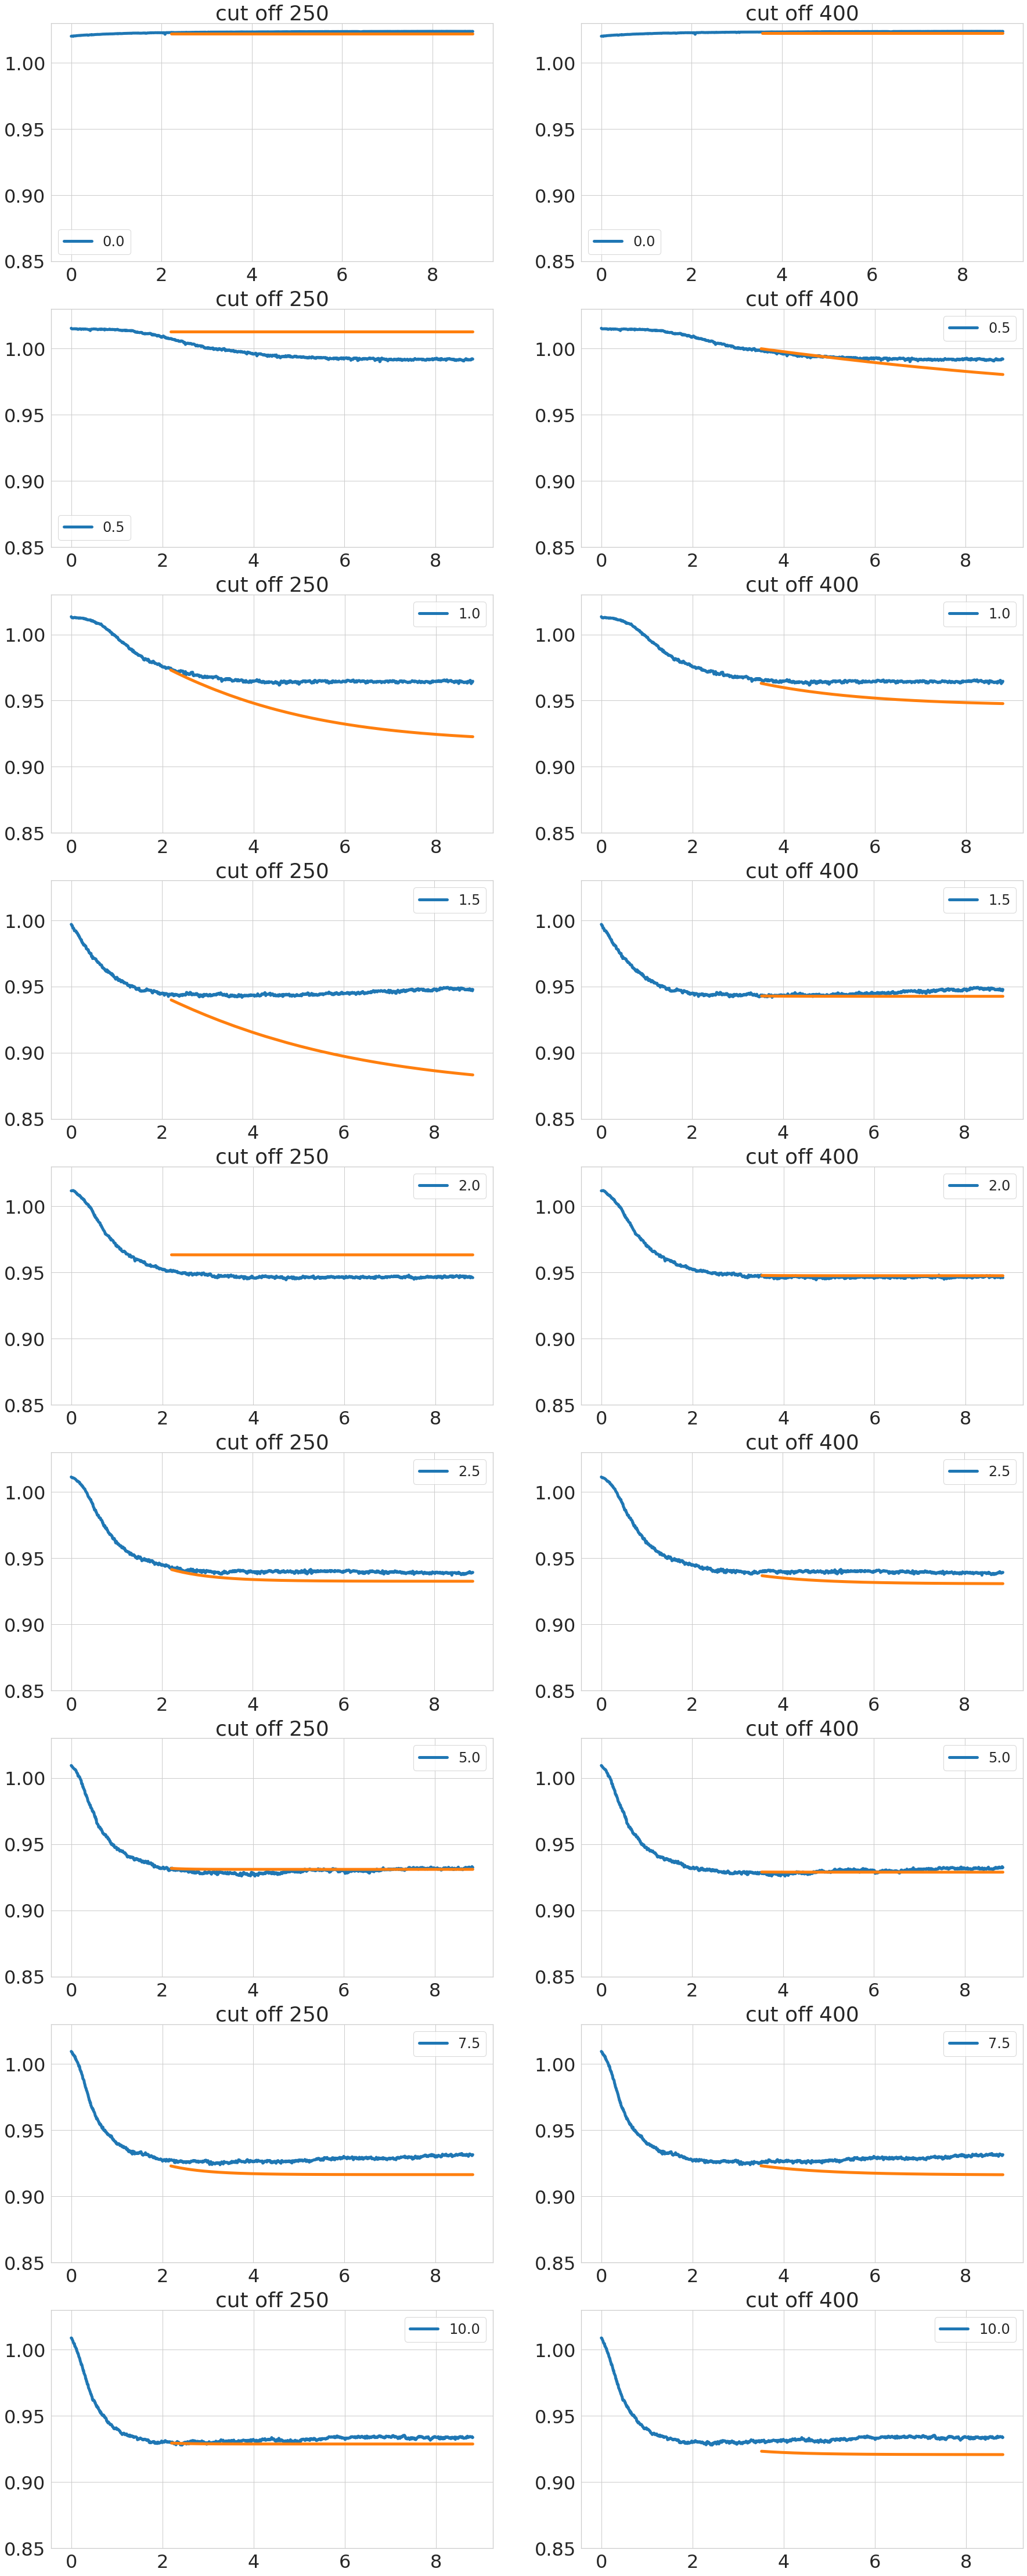

In [96]:

num_curves = sum([len(val_data) for _, _, val_data in models_and_validation_data])

fig, axes = plt.subplots(num_curves, 2, figsize=(30, 80))

volt_prediction_label_pairs_250 = [
    (
        extrapolated_series,
        glucose_predictions,
        real_series
    )   
    for (volt_predictions, glucose_predictions), val_data_group in 
        zip(
            volt_and_glc_predictions_250,
            [val_data for _, _, val_data in models_and_validation_data]
        )
    for extrapolated_series, real_series in zip(volt_predictions, val_data_group)
]

volt_prediction_label_pairs_400 = [
    (
        extrapolated_series,
        glucose_predictions,
        real_series
    )   
    for (volt_predictions, glucose_predictions), val_data_group in 
        zip(
            volt_and_glc_predictions_400,
            [val_data for _, _, val_data in models_and_validation_data]
        )
    for extrapolated_series, real_series in zip(volt_predictions, val_data_group)
]



for idx, (volt_predictions, _, label_series) in enumerate(
    sorted(volt_prediction_label_pairs_250, key=lambda one: one[2].real_concentration)
):
    ax = axes[idx, 0]
    ax.plot(
        label_series.points_in_time,
        label_series.voltages,
        label=label_series.real_concentration
    
    )
    ax.plot(
        label_series.points_in_time[250:],
        volt_predictions
    )
    ax.set_title('cut off 250')
    ax.set_ylim((0.85, 1.03))
    ax.legend()


for idx, (volt_predictions, _, label_series) in enumerate(
    sorted(volt_prediction_label_pairs_400, key=lambda one: one[2].real_concentration)
):
    ax = axes[idx, 1]
    ax.plot(
        label_series.points_in_time,
        label_series.voltages,
        label=label_series.real_concentration
    
    )
    ax.plot(
        label_series.points_in_time[400:],
        volt_predictions
    )
    ax.set_title('cut off 400')
    ax.set_ylim((0.85, 1.03))
 
    ax.legend()




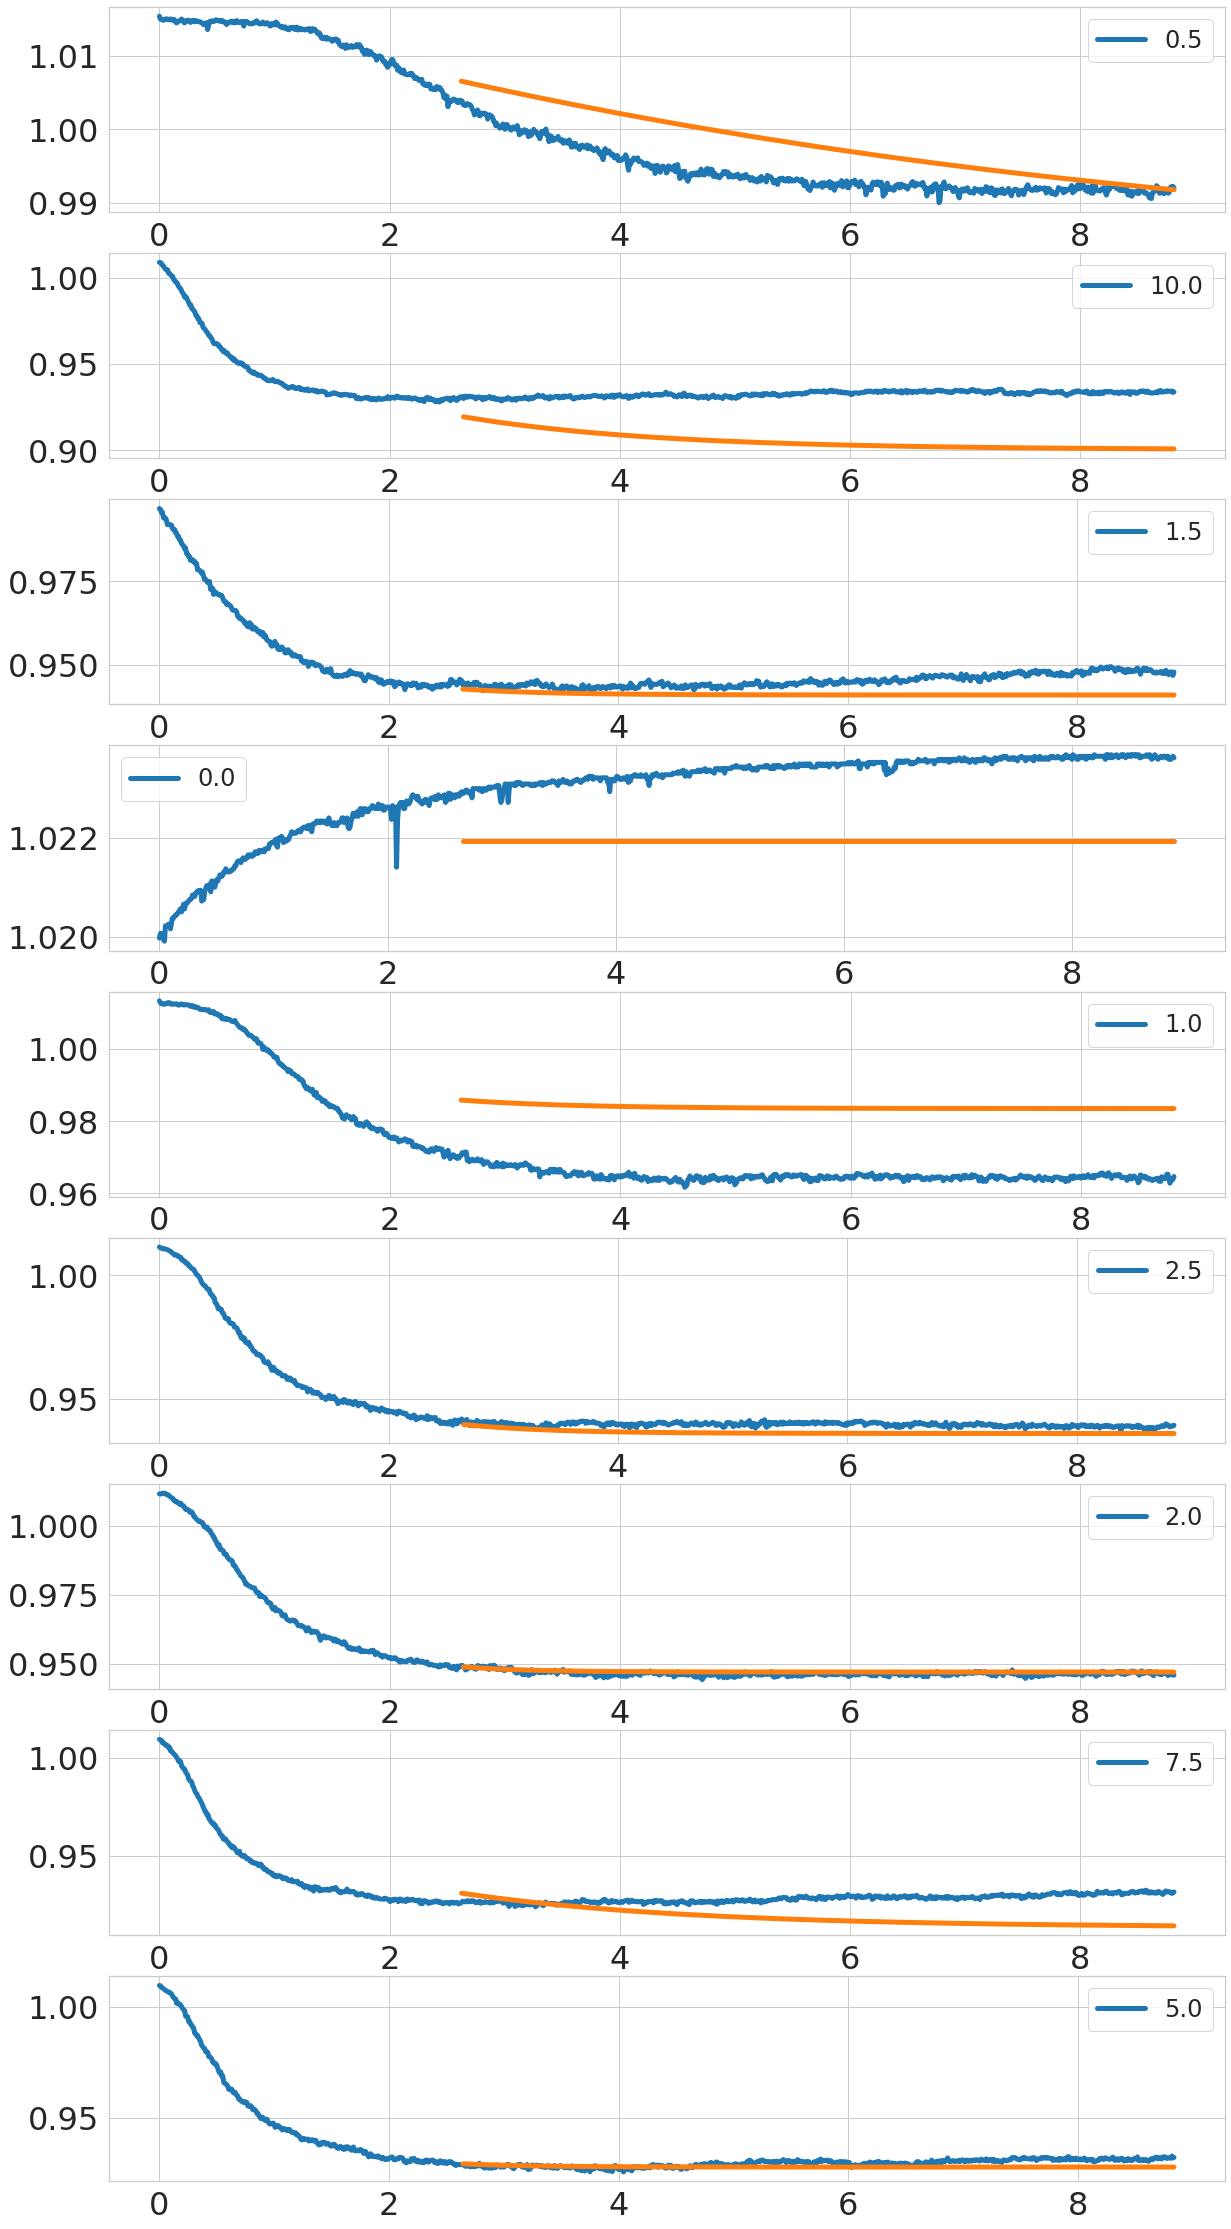

In [70]:

num_curves = sum([len(val_data) for _, _, val_data in models_and_validation_data])

fig, axes = plt.subplots(num_curves, 1, figsize=(20, 40))

volt_prediction_label_pairs = [
    (
        extrapolated_series,
        glucose_predictions,
        real_series
    )   
    for (volt_predictions, glucose_predictions), val_data_group in 
        zip(
            volt_and_glc_predictions,
            [val_data for _, _, val_data in models_and_validation_data]
        )
    for extrapolated_series, real_series in zip(volt_predictions, val_data_group)
]

time = np.linspace(0., 9., 1000)

for ax, (volt_predictions, _, label_series) in zip(axes.flatten(), volt_prediction_label_pairs):
    
    ax.plot(
        label_series.points_in_time,
        label_series.voltages,
        label=label_series.real_concentration
    
    )
    ax.plot(
        label_series.points_in_time[CUT_OFF_IDX:],
        volt_predictions
    )

    ax.legend()




In [32]:
predictions.shape, validation_data[0].real_concentration, validation_data[0].voltages.shape

((1, 800), 7.5, (1000,))

In [ ]:
predicted_voltages, predicted_glucose = zip(*[
    glucose_ts.evaluation.both_models.glucose_performance(
        glucose_time_series=val_data,
        glucose_model=glcs_model,
#         voltage_model=volt_model,
        cut_off_idx=200,
        avg_start_idx=800,
        upper_glucose_bound=3,
    )
    for volt_model, glcs_model, val_data in output
])
predicted_glucose

In [ ]:
model_results = [
    glucose_ts.evaluation.both_models.glucose_performance(
        glucose_time_series=val_data,
        glucose_model=glcs_model,
        voltage_model=volt_model,
        cut_off_idx=220,
        avg_start_idx=700,
        upper_glucose_bound=3,
    )
    for volt_model, glcs_model, val_data in output
]
print(model_results)
print(sum([one['rmse'] * one['num_evaluations'] for one in model_results]) / sum([one['num_evaluations'] for one in model_results]))

In [ ]:
[[one.real_concentration for one in data] for _, _, data in output]